In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cell 2: Fonctions d'activation
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    x_clipped = np.clip(x, -500, 500)
    result = 1 / (1 + np.exp(-x_clipped))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    sig = sigmoid(x)
    result = sig * (1 - sig)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result

In [3]:
# Cell 3: Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z-{i+1} has incorrect shape"
            self.z_values.append(z)
            if i < len(self.weights) - 2:
                a = relu(z)
                assert a.shape == (X.shape[0], self.layer_sizes[i+1]), f"A-{i+1} has incorrect shape"
                self.activations.append(a)
            else:
                a = sigmoid(z)
                assert a.shape == (X.shape[0], self.layer_sizes[i+1]), f"A-{i+1} has incorrect shape"
                self.activations.append(a)
        # Dernière couche de sortie
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert isinstance(z, np.ndarray), "Output Z must be a numpy array"
        assert z.shape[0] == X.shape[0], "Output Z must have the same number of samples as input X"
        assert z.shape[1] == self.layer_sizes[-1], f"Output Z must have {self.layer_sizes[-1]} columns"
        self.z_values.append(z)
        output = sigmoid(z)
        self.activations.append(output)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        return output

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        predictions = (y_pred >= 0.5).astype(int)
        assert predictions.shape == y_true.shape, "Predictions have incorrect shape"
        correct_predictions = np.sum(predictions == y_true)
        accuracy = correct_predictions / y_true.shape[0]
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            assert dA.shape == self.activations[i + 1].shape, "dA has incorrect shape"
            dZ = dA * relu_derivative(self.z_values[i])
            assert dZ.shape == self.activations[i + 1].shape, "dZ has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            lambda_reg = 0.01
            self.d_weights[i] += lambda_reg * self.weights[i] / m
        assert all(d.shape == w.shape for d, w in zip(self.d_weights, self.weights)), "d_weights have incorrect shapes"
        assert all(d.shape == b.shape for d, b in zip(self.d_biases, self.biases)), "d_biases have incorrect shapes"

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]
            assert self.weights[i].shape == self.d_weights[i].shape, f"Updated weights {i+1} have incorrect shape"
            assert self.biases[i].shape == self.d_biases[i].shape, f"Updated biases {i+1} have incorrect shape"

    def predict_proba(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        assert outputs.shape == (X.shape[0], self.layer_sizes[-1]), "Outputs have incorrect shape"
        return outputs

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.ndim == 2 and y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[indices[i:i + batch_size]]
                y_batch = y[indices[i:i + batch_size]]
                assert X_batch.shape[0] == batch_size or (i + batch_size >= X.shape[0] and X_batch.shape[0] < batch_size), "Batch size must match specified batch size"
                assert y_batch.shape[0] == X_batch.shape[0], "y_batch must have the same number of samples as X_batch"
                assert X_batch.shape[1] == self.layer_sizes[0], f"Batch input dimension ({X_batch.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
                assert y_batch.shape[1] == self.layer_sizes[-1], f"Batch output dimension ({y_batch.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_accuracy = self.compute_accuracy(y, self.predict_proba(X))
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_accuracy = self.compute_accuracy(y_val, self.predict_proba(X_val))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        predictions = (outputs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

In [4]:
# Cell 4: Chargement et préparation des données
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Target variable
assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"
if y.ndim == 1:
    y = y.reshape(-1, 1)

# Standardisation
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

In [5]:
# Cell 5: Entraînement du modèle de base
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

Epoch 0, Train Loss: 0.7156, Val Loss: 0.6592, Train Acc: 0.6522, Val Acc: 0.6429
Epoch 10, Train Loss: 0.6708, Val Loss: 0.6251, Train Acc: 0.6500, Val Acc: 0.6494
Epoch 20, Train Loss: 0.6468, Val Loss: 0.5990, Train Acc: 0.6696, Val Acc: 0.6623
Epoch 30, Train Loss: 0.6273, Val Loss: 0.5745, Train Acc: 0.6870, Val Acc: 0.6883
Epoch 40, Train Loss: 0.6107, Val Loss: 0.5518, Train Acc: 0.7109, Val Acc: 0.7208
Epoch 50, Train Loss: 0.5795, Val Loss: 0.5314, Train Acc: 0.7152, Val Acc: 0.7468
Epoch 60, Train Loss: 0.5631, Val Loss: 0.5135, Train Acc: 0.7370, Val Acc: 0.7597
Epoch 70, Train Loss: 0.5503, Val Loss: 0.4980, Train Acc: 0.7457, Val Acc: 0.7597
Epoch 80, Train Loss: 0.5354, Val Loss: 0.4853, Train Acc: 0.7565, Val Acc: 0.7662
Epoch 90, Train Loss: 0.5240, Val Loss: 0.4757, Train Acc: 0.7630, Val Acc: 0.7727


In [6]:
# Cell 6: Validation croisée
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]
    nn_cv = NeuralNetwork(layer_sizes, learning_rate=0.01)
    nn_cv.train(X_train_cv, y_train_cv, X_val_cv, y_val_cv, epochs=50, batch_size=32)
    y_pred_cv = nn_cv.predict(X_val_cv)
    acc = nn_cv.compute_accuracy(y_val_cv, y_pred_cv)
    cv_accuracies.append(acc)
    print(f"Fold {fold+1}/{n_splits} - Validation Accuracy: {acc:.4f}")

print(f"\nValidation croisée: Accuracy moyenne = {np.mean(cv_accuracies):.4f} (+/- {np.std(cv_accuracies):.4f})")

Epoch 0, Train Loss: 0.6872, Val Loss: 0.6606, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Train Loss: 0.6491, Val Loss: 0.6234, Train Acc: 0.6596, Val Acc: 0.6299
Epoch 20, Train Loss: 0.6236, Val Loss: 0.5956, Train Acc: 0.6792, Val Acc: 0.6494
Epoch 30, Train Loss: 0.5870, Val Loss: 0.5713, Train Acc: 0.7117, Val Acc: 0.7078
Epoch 40, Train Loss: 0.5617, Val Loss: 0.5482, Train Acc: 0.7264, Val Acc: 0.7143
Fold 1/5 - Validation Accuracy: 0.7208
Epoch 0, Train Loss: 0.6914, Val Loss: 0.6593, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Train Loss: 0.6640, Val Loss: 0.6158, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 20, Train Loss: 0.6266, Val Loss: 0.5858, Train Acc: 0.6694, Val Acc: 0.6753
Epoch 30, Train Loss: 0.6054, Val Loss: 0.5554, Train Acc: 0.7036, Val Acc: 0.7208
Epoch 40, Train Loss: 0.5801, Val Loss: 0.5289, Train Acc: 0.7101, Val Acc: 0.7338
Fold 2/5 - Validation Accuracy: 0.7468
Epoch 0, Train Loss: 0.6924, Val Loss: 0.6697, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Tr

In [7]:
# Cell 7: Implémentation de l'optimiseur Adam
class AdamNeuralNetwork(NeuralNetwork):
    def __init__(self, layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(layer_sizes, learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.t = 0

    def backward(self, X, y, outputs):
        super().backward(X, y, outputs)
        self.t += 1
        for i in range(len(self.weights)):
            # Adam update for weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
            m_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            # Adam update for biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)
            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

In [8]:
# Cell 8: Entraînement avec Adam
adam_nn = AdamNeuralNetwork(layer_sizes, learning_rate=0.001)
adam_train_losses, adam_val_losses, adam_train_accuracies, adam_val_accuracies = adam_nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)
print("Adam optimizer - Test accuracy:", adam_nn.compute_accuracy(y_test, adam_nn.predict(X_test)))

Epoch 0, Train Loss: 0.7128, Val Loss: 0.6531, Train Acc: 0.6522, Val Acc: 0.6429
Epoch 10, Train Loss: 0.6266, Val Loss: 0.5799, Train Acc: 0.6848, Val Acc: 0.6948
Epoch 20, Train Loss: 0.5754, Val Loss: 0.5268, Train Acc: 0.7348, Val Acc: 0.7468
Epoch 30, Train Loss: 0.5399, Val Loss: 0.4911, Train Acc: 0.7609, Val Acc: 0.7662
Epoch 40, Train Loss: 0.5300, Val Loss: 0.4672, Train Acc: 0.7717, Val Acc: 0.7662
Epoch 50, Train Loss: 0.4946, Val Loss: 0.4557, Train Acc: 0.7783, Val Acc: 0.7857
Epoch 60, Train Loss: 0.4844, Val Loss: 0.4515, Train Acc: 0.7826, Val Acc: 0.7857
Epoch 70, Train Loss: 0.4858, Val Loss: 0.4476, Train Acc: 0.7826, Val Acc: 0.7792
Epoch 80, Train Loss: 0.4801, Val Loss: 0.4451, Train Acc: 0.7913, Val Acc: 0.7792
Epoch 90, Train Loss: 0.4722, Val Loss: 0.4464, Train Acc: 0.7957, Val Acc: 0.7727
Adam optimizer - Test accuracy: 0.7402597402597403



Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154

Distribution des classes prédites : {np.int64(0): np.int64(108), np.int64(1): np.int64(46)}


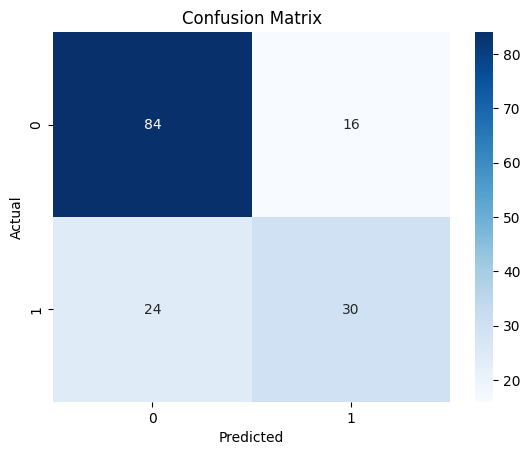

In [9]:
# Cell 9: Prédictions et évaluation du modèle de base
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

unique, counts = np.unique(y_pred, return_counts=True)
print("Distribution des classes prédites :", dict(zip(unique.flatten(), counts)))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

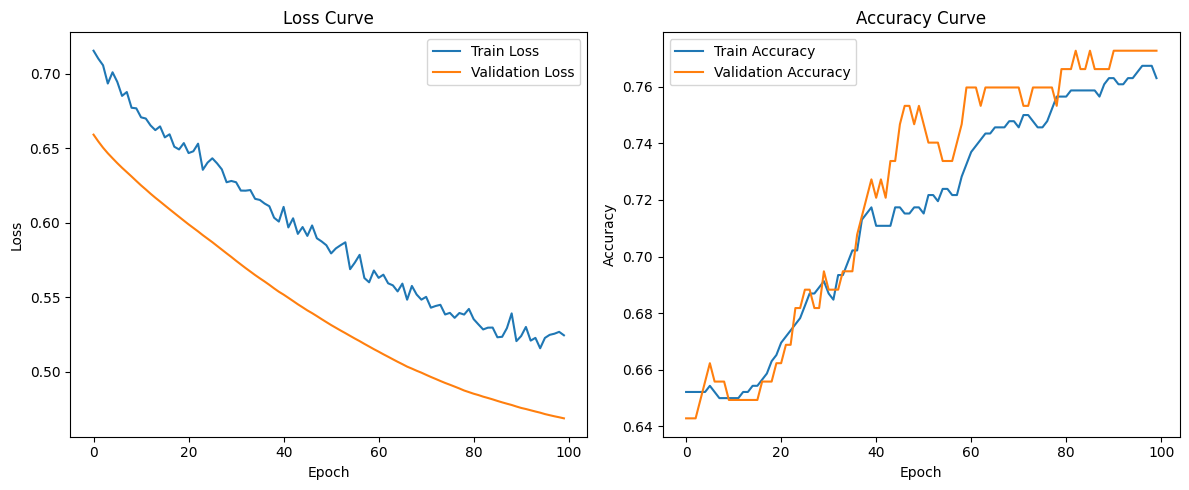

(array([0, 1]), array([500, 268]))
Distribution des classes dans y : {np.int64(0): np.int64(500), np.int64(1): np.int64(268)}


In [10]:
# Cell 10: Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()
print(np.unique(y, return_counts=True))
print("Distribution des classes dans y :", dict(zip(*np.unique(y, return_counts=True))))